# Sam's Remix

This is from Samuel Hinton, who so kindly remixed my Reddit Post. 

You can find his blog with the remix [here](https://cosmiccoding.com.au/tutorials/us_covid19_growth)

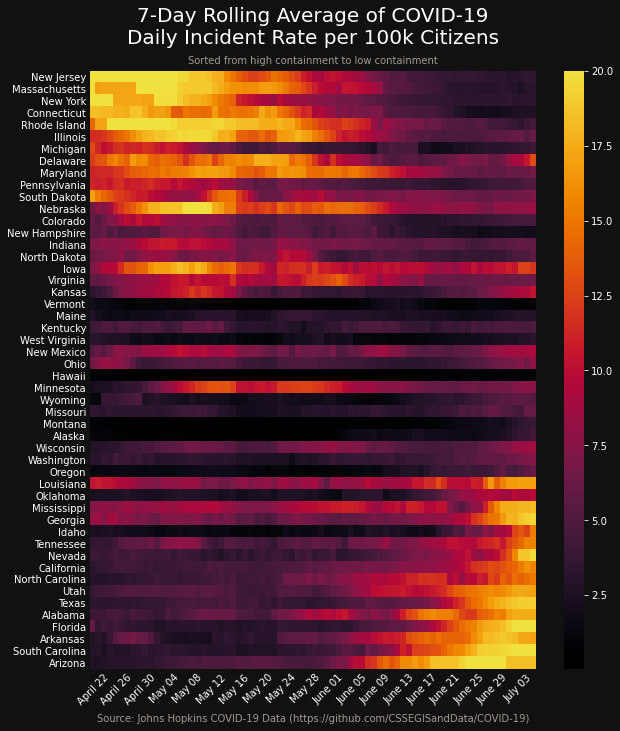

In [20]:
import cmasher as cmr
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns


# Some config variables that Im going to break scope with, forgive me.

# Dir where you clone out https://github.com/CSSEGISandData/COVID-19
data_directory = "/Users/davidmorton/Documents/COVID-19/csse_covid_19_data/csse_covid_19_daily_reports_us/"
states_to_drop = ['Puerto Rico', 'American Samoa', 'Guam', 'District of Columbia', 
                  'Diamond Princess', 'Northern Mariana Islands', 'Virgin Islands',
                 'Recovered', "Grand Princess"]
columns_to_keep = ["Province_State", "Incident_Rate"]

def load_csv(directory, filename):
    # davidmorton: Used the filename to set the date.
    date = filename.replace(".csv", "")
    df = pd.read_csv(os.path.join(directory, filename))[columns_to_keep]
    df["date"] = pd.to_datetime(date, format="%m-%d-%Y")
    return df

def load_data(directory):
    # davidmorton: Elegant way to gather all the files and load them all. 
    files = [f for f in os.listdir(directory) if f.endswith(".csv")]
    dataframes = [load_csv(directory, f) for f in files]
    df_all = pd.concat(dataframes)
    # davidmorton: Renamed the columns to something simpler to deal with. I should have done this much earlier.
    df_all = df_all.rename(columns={"Province_State": "state", 
                                    "Incident_Rate": "rate"})
    return df_all[~df_all.state.isin(states_to_drop)]

# Load all the data into long format
df_long = load_data(data_directory)

# Pivot into a 2D format and sort the columns
# davidmorton: Added the values here, and then commented out the droplevel. 
df_wide = df_long.pivot(index="date", columns="state", values='rate')
#print(df_wide)
#df_wide.columns = df_wide.columns.droplevel()


# Take the difference to get the change in incidence. 
# Drop the first row as its all NaN
df_diff = df_wide.diff().iloc[1:, :]

# There seems to be some odd spikes in the data. 
# In fact, from look at each state individually,
# this data is definitely incorrect in some way. 
# Many states have a drop by 20 to 60% in the number
# of accumulated cases at the start of May... 
# For now, Ill just clip the data
df_diff = df_diff.clip(0, 20)

# davidmorton: Older days are weighted less, and thus count less in the sort. 
day_of_year = df_diff.index.dayofyear.to_numpy()
day_weight = day_of_year - day_of_year.mean()
sort_weight = (df_diff.T * day_weight).sum(axis=1)

# davidmorton: a different way to reindex, and likely a better one here. 
df_sorted = df_diff.iloc[:, sort_weight.argsort()].T

def plot_evolution(dfo, smooth=7, cmap=None):
    # Optionally smooth the data
    df = dfo.rolling(smooth, axis=1).mean().iloc[:, smooth - 1:] if smooth else dfo
        
    if cmap is None: # Default to using cmasher's ember colorscale. Thanks Ellert.
        cmap = plt.get_cmap('cmr.ember') 
    
    # Set up plotting style with dark bg
    with plt.style.context("dark_background"):
        fig, ax = plt.subplots(figsize=(10, 11))
        idx = [d.strftime("%B %d") for d in df.columns]
        xlabels = [x if i % 4 == 3 else "" for i, x in enumerate(idx)]
        sns.heatmap(df, ax=ax, cmap=cmap, xticklabels=xlabels, cbar_kws={"aspect": 30})
        ax.set_xticklabels(labels=xlabels, rotation=45, ha="right")
        ax.tick_params(axis='both', which='both', length=0)
        ax.set_xlabel('')
        ax.set_ylabel('')
        fig.patch.set_facecolor('#111111')
        ax.set_title('7-Day Rolling Average of COVID-19\nDaily Incident Rate per 100k Citizens\n', 
                     size=20, pad=5)
        ax.annotate('Source: Johns Hopkins COVID-19 Data (https://github.com/CSSEGISandData/COVID-19)', 
                    (0.5,0), (0, -45), xycoords='axes fraction', color="#a19a92",
                    textcoords='offset points', size=10, va='top', ha="center")
        ax.annotate('Sorted from high containment to low containment', 
                    (0.5,1), (0, 15), xycoords='axes fraction', color="#a19a92",
                    textcoords='offset points', size=10, va='top', ha="center")
        fig.savefig("covid19-samsremix.png", dpi=300, bbox_inches="tight", pad_inches=0.5, 
                    facecolor=fig.get_facecolor())

plot_evolution(df_sorted)